### Audio Event Classifier with Deep Learning

Build a CNN sound classifier using melspectograms from OSF data.

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.applications.vgg16 import preprocess_input
from keras.utils import multi_gpu_model
import numpy as np
import json
import PIL

# Set parameter values

In [2]:
batch_size = 40
epochs = 50

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

nb_training_samples = 3716
nb_validation_samples = 1219# Set parameter values

# Configure training and validation data generators

Provide paths to training and testing set directores

In [3]:
# training generator configuration
training_data_dir = '/Users/xt/Desktop/OSF/melspectrograms/train/'

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir ='/Users/xt/Desktop/OSF/melspectrograms/validation/'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 3716 images belonging to 2 classes.
Found 1219 images belonging to 2 classes.


# Load base model

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()

Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128

# Build top model

In [5]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________


# Combine base model with top model

In [6]:
# top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Configure model training

In [7]:
num_layers_to_freeze = 15

In [8]:
from keras import metrics, optimizers

def top_1_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=1)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# use nesterov accelrated gradient descent ??
# optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_1_accuracy])

# parallel_model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
#                       loss='categorical_crossentropy', 
#                       metrics=['accuracy', top_1_accuracy])

# serialize model to JSON
model_json = model.to_json()
model_filename = "vgg16_model_{}_frozen_layers.json".format(num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

# Fine-tune the model

In [9]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/layers_frozen_{}".format(num_layers_to_freeze))

# checkpoint
filepath="esc50_vgg16_stft_weights_train_last_2_base_layers.best.hdf5"
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard]

# parallel_model.fit_generator(
#     training_generator,
#     steps_per_epoch=nb_training_samples/batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples/batch_size,
#     callbacks=callbacks_list)

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)
# parallel_model.fit_generator(
#     training_generator,
#     samples_per_epoch=nb_training_samples,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples/batch_size,)
#     nb_val_samples=nb_validation_samples)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
93/92 [==============================] - 807s 9s/step - loss: 0.6407 - accuracy: 0.6445 - top_1_accuracy: 0.6445 - val_loss: 0.5458 - val_accuracy: 0.7383 - val_top_1_accuracy: 0.7383
Epoch 2/50
93/92 [==============================] - 795s 9s/step - loss: 0.5538 - accuracy: 0.7010 - top_1_accuracy: 0.7010 - val_loss: 0.5025 - val_accuracy: 0.7498 - val_top_1_accuracy: 0.7498
Epoch 3/50
93/92 [==============================] - 786s 8s/step - loss: 0.5201 - accuracy: 0.7330 - top_1_accuracy: 0.7330 - val_loss: 0.4698 - val_accuracy: 0.7769 - val_top_1_accuracy: 0.7769
Epoch 4/50
93/92 [==============================] - 783s 8s/step - loss: 0.5071 - accuracy: 0.7419 - top_1_accuracy: 0.7419 - val_loss: 0.4646 - val_accuracy: 0.7760 - val_top_1_accuracy: 0.7760
Epoch 5/50
93/92 [==============================] - 783s 8s/step - loss: 0.4872 - accuracy: 0.7489 - top_1_accuracy: 0.7489 - val_loss: 0.4384 -

Epoch 22/50
93/92 [==============================] - 822s 9s/step - loss: 0.3530 - accuracy: 0.8326 - top_1_accuracy: 0.8326 - val_loss: 0.3547 - val_accuracy: 0.8450 - val_top_1_accuracy: 0.8450
Epoch 23/50
93/92 [==============================] - 796s 9s/step - loss: 0.3353 - accuracy: 0.8450 - top_1_accuracy: 0.8450 - val_loss: 0.3506 - val_accuracy: 0.8507 - val_top_1_accuracy: 0.8507
Epoch 24/50
93/92 [==============================] - 786s 8s/step - loss: 0.3341 - accuracy: 0.8485 - top_1_accuracy: 0.8485 - val_loss: 0.3474 - val_accuracy: 0.8482 - val_top_1_accuracy: 0.8482
Epoch 25/50
93/92 [==============================] - 780s 8s/step - loss: 0.3277 - accuracy: 0.8544 - top_1_accuracy: 0.8544 - val_loss: 0.3445 - val_accuracy: 0.8491 - val_top_1_accuracy: 0.8491
Epoch 26/50
93/92 [==============================] - 774s 8s/step - loss: 0.3162 - accuracy: 0.8579 - top_1_accuracy: 0.8579 - val_loss: 0.3408 - val_accuracy: 0.8441 - val_top_1_accuracy: 0.8441
Epoch 27/50
93/92 [=

93/92 [==============================] - 783s 8s/step - loss: 0.2409 - accuracy: 0.8972 - top_1_accuracy: 0.8972 - val_loss: 0.3353 - val_accuracy: 0.8597 - val_top_1_accuracy: 0.8597
Epoch 44/50
93/92 [==============================] - 784s 8s/step - loss: 0.2580 - accuracy: 0.8878 - top_1_accuracy: 0.8878 - val_loss: 0.4124 - val_accuracy: 0.8130 - val_top_1_accuracy: 0.8130
Epoch 45/50
93/92 [==============================] - 783s 8s/step - loss: 0.2420 - accuracy: 0.8950 - top_1_accuracy: 0.8950 - val_loss: 0.3376 - val_accuracy: 0.8523 - val_top_1_accuracy: 0.8523
Epoch 46/50
93/92 [==============================] - 784s 8s/step - loss: 0.2266 - accuracy: 0.9053 - top_1_accuracy: 0.9053 - val_loss: 0.3519 - val_accuracy: 0.8523 - val_top_1_accuracy: 0.8523
Epoch 47/50
93/92 [==============================] - 788s 8s/step - loss: 0.2241 - accuracy: 0.9029 - top_1_accuracy: 0.9029 - val_loss: 0.3467 - val_accuracy: 0.8532 - val_top_1_accuracy: 0.8532
Epoch 48/50
93/92 [=============

# Get top k predictions for selected test files

In [10]:
def get_top_k_predictions(preds, label_map, k=1, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print ("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

In [11]:
label_map = (training_generator.class_indices)
 
json2 = json.dumps(label_map)
f = open("cough_label_map.json","w")
f.write(json2)
f.close()

img_path = '/Users/xt/Desktop/OSF/melspectrograms/test/sick/audioset__3RvCwwIZ4w_10_15.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)* 1./255

preds = model.predict(x)[0]

get_top_k_predictions(preds, label_map, k=1)

['not_sick', 'sick']

# Calculate and plot confusion matrix

In [12]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix


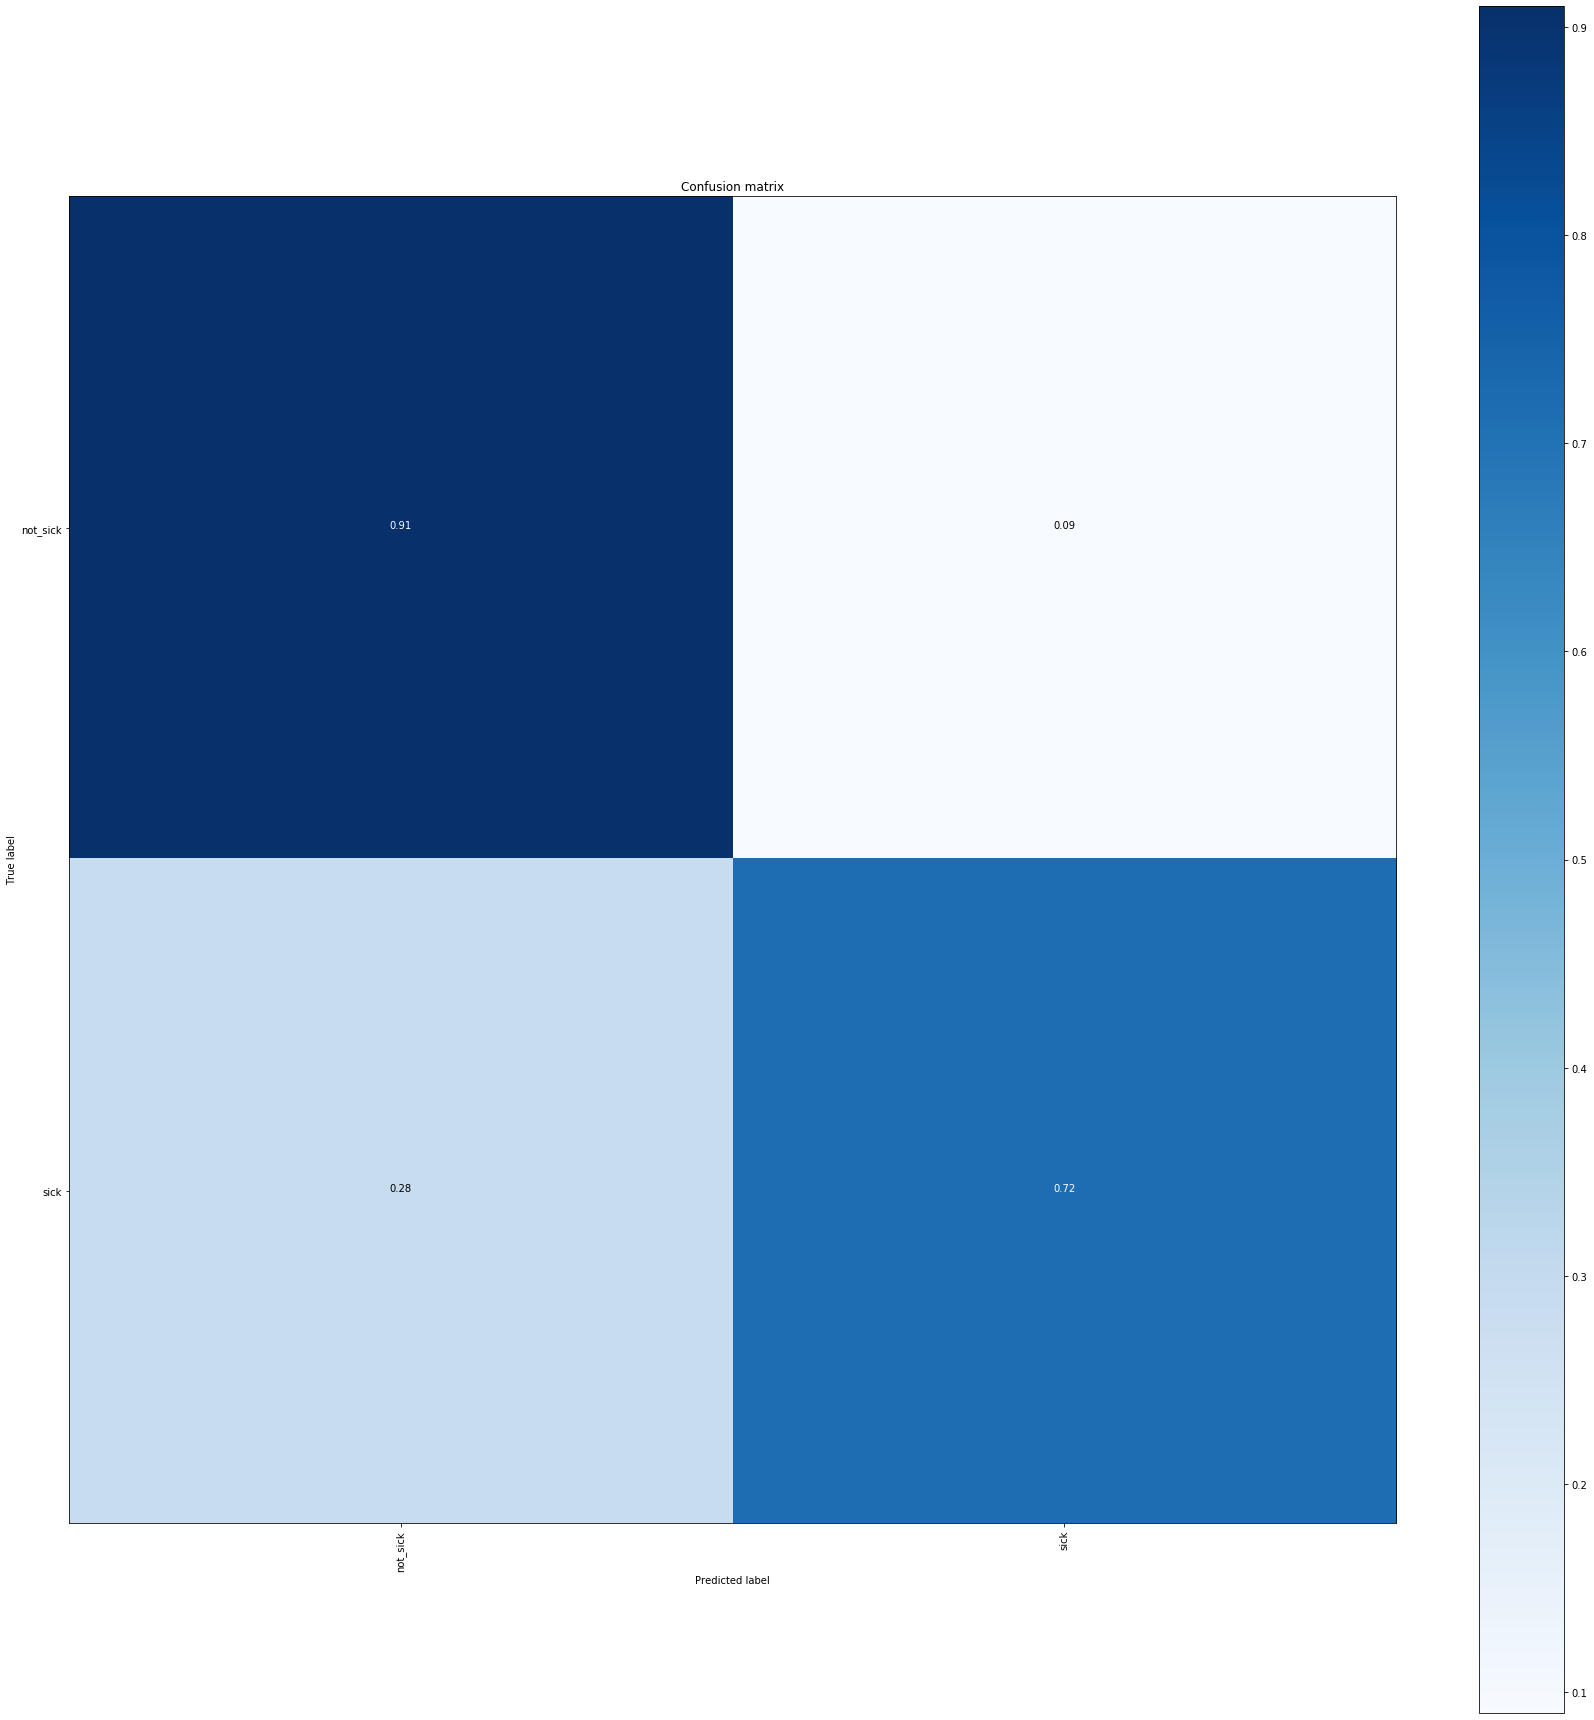

In [13]:
import os
import io
import requests
import urllib.request
from PIL import Image
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix

testing_dir = '/Users/xt/Desktop/OSF/melspectrograms/test/'

y_true = []
y_pred = []
for label in label_map.keys():
    file_list = os.listdir(testing_dir + label)
    for file_name in file_list:
        if file_name != '.DS_Store':
            img_path = testing_dir + label + '/' + file_name
            img = image.load_img(img_path, target_size=(224, 224))
            
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)* 1./255
            
            preds = model.predict(x)[0]
            
            y_true.append(label)
            y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True)